In [2]:
import os, sys, time, json, re, io
import base64
import dotenv
import requests
import subprocess
import pandas as pd
from datasets import load_dataset

from IPython.display import display, HTML
from PIL import Image 

dotenv.load_dotenv("../.env")
sys.path.append("..")
from eg1.utils import log_and_raise_for_status

EG1_API_URL = "http://localhost:8000/v1"
#EG1_API_URL = "https://eg1.dev.etalab.gouv.fr/v1"
EG1_API_KEY = os.getenv("EG1_API_KEY") 
ALBERT_API_URL = "https://albert.api.etalab.gouv.fr/v1"
ALBERT_API_KEY = os.getenv("ALBERT_API_KEY")

eg1_headers = {"Authorization": f"Bearer {EG1_API_KEY}"}
albert_headers = {"Authorization": f"Bearer {ALBERT_API_KEY}"}

In [3]:
# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("datalab-to/marker_benchmark")

In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['gt_blocks', 'img', 'page_bbox', 'classification', 'language', 'pdf', 'uuid'],
        num_rows: 2138
    })
})

In [5]:
# What a row contains 

for key, value in ds["train"][1261].items():
    print(key, type(value))

gt_blocks <class 'str'>
img <class 'PIL.PngImagePlugin.PngImageFile'>
page_bbox <class 'list'>
classification <class 'str'>
language <class 'str'>
pdf <class 'bytes'>
uuid <class 'int'>


In [6]:
# Example of the first block content (gt_blocks)

jsb = json.loads(ds["train"][0]["gt_blocks"])

for block in jsb:
    print(list(block))
    print(block)
    break

['html', 'bbox', 'polygon', 'block_type', 'block_idx']
{'html': '<p>substudy of precursors of depression, where half the participants displayed elevated depressive symptoms and half did not (Appendix S1). Written assent/consent was obtained for all participants and their parents, and monetary compensation was provided. Study procedures were approved by the Human Protections Committee and Institutional Review Board of the study sites.</p>', 'bbox': [44.234375, 77.2880859375, 288.978515625, 146.90252685546875], 'polygon': [[44.234375, 77.2880859375], [288.978515625, 77.2880859375], [288.978515625, 146.90252685546875], [44.234375, 146.90252685546875]], 'block_type': 'Text', 'block_idx': 0}


In [7]:
def display_dataset_row(row):
    """
    Display a dataset row nicely in a Jupyter notebook.
    
    Args:
    - row: dictionary containing elements like 'gt_blocks', 'img', etc.
    """
    for key, value in row.items():
        if isinstance(value, Image.Image):  # Use Image.Image to check for PIL images
            print(f"{key}: Image")
            display(value)
        elif key == "gt_blocks":
            blocks = json.loads(value)
            print(f'{len(blocks)} blocks. Block types: {[x.get("block_type") for x in blocks]}')
            #for block in blocks:
            #    print(block["html"])
        elif isinstance(value, str):
            print(f"{key}: {value}")
        elif isinstance(value, list):
            print(f"{key}: {value}")
        elif isinstance(value, int):
            print(f"{key}: {value}")
        elif isinstance(value, bytes):
            print(f"{key}: {len(value)} bytes")
        else:
            print(f"{key}: {type(value)} (unable to display)")

def image_to_base64(pil_image):
    """
    Convert a PIL image to a base64-encoded PNG bytes string.
    """
    with io.BytesIO() as buffer:
        pil_image.save(buffer, format="PNG")
        return base64.b64encode(buffer.getvalue()).decode("utf-8")

def extract_code(text: str):
    """Return the last code block found"""
    # Find all blocks of code wrapped in triple backticks
    matches = re.findall(r"```(?:\w+)?\n(.*?)```", text, re.DOTALL)
    if matches:
        # Return the last code block found
        code = matches[-1]
        # Remove any leading or trailing whitespace
        code = code.strip()
        return code

    return text.strip()


def pandoc(content, input_format="html", output_format="markdown"):
    """
    Convert HTML to Markdown using Pandoc

    Parameters:
    - html_content: The HTML string to convert
    - output_format: The specific Markdown flavor (e.g., "markdown", "markdown_strict", "gfm" for GitHub-flavored Markdown)

    Returns:
    - Markdown text
    """
    # Create a process that runs pandoc
    process = subprocess.Popen(
        ['pandoc', '-f', input_format, '-t', output_format],
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )

    # Send the HTML content to pandoc and get the output
    new_content, error = process.communicate(input=content)
    if process.returncode != 0:
        raise Exception(f"Pandoc conversion failed: {error}")

    return new_content


13 blocks. Block types: ['Text', 'SectionHeader', 'Text', 'Text', 'Text', 'SectionHeader', 'Text', 'Text', 'Text', 'SectionHeader', 'Text', 'SectionHeader', 'Text']
img: Image


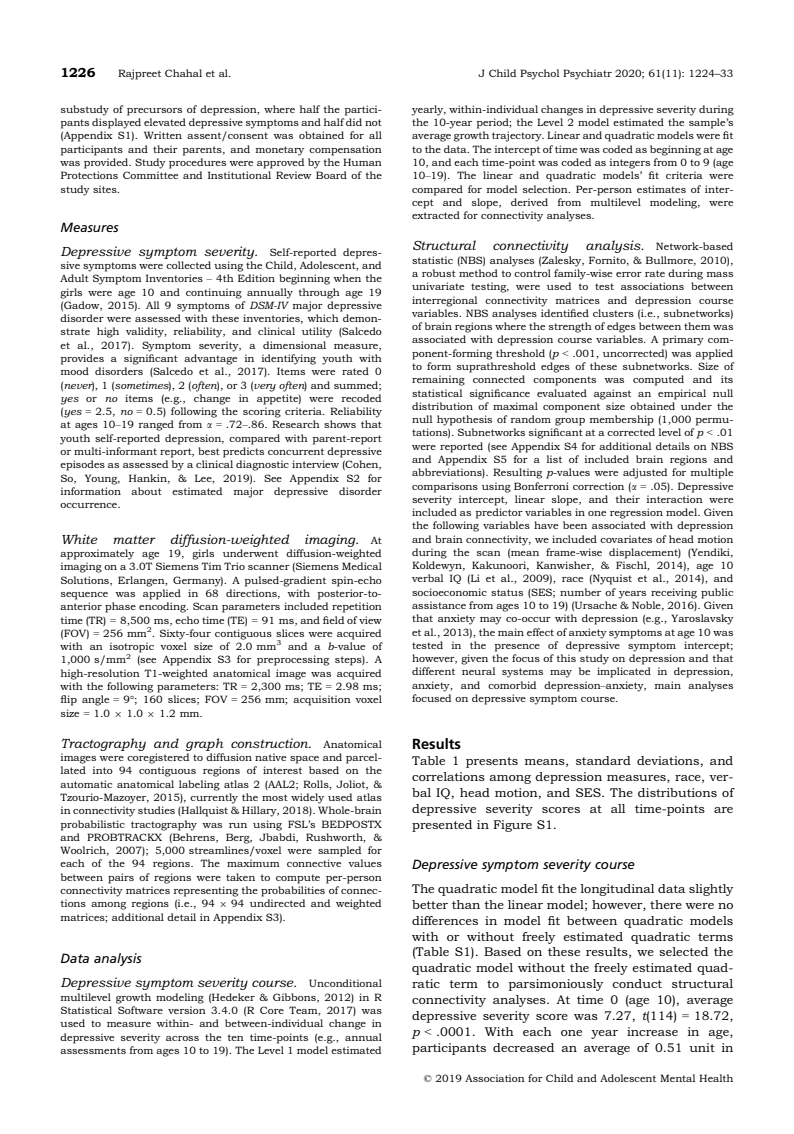

page_bbox: [0.0, 0.0, 794.0, 1134.0]
classification: Scientific paper
language: English
pdf: 50177 bytes
uuid: 0


In [8]:
display_dataset_row(ds["train"][0])

In [9]:
system_prompt = """You are tasked with generating a JSON representation from the analysis (OCR) of a given image. 
Your goal is to create a JSON object that has the content of the image extracted in a structured format. 

The JSON should be structured to represent the content of the image in a way that corresponds to standard markdown primitives. Here's how to approach this task:

The JSON should contain a list of blocks, where each block represents a distinct element in the image, such as headers, paragraphs, or tables.
Here is a an exemple of the json schema wanted: 

```json
[
 {
   "type": "string (e.g  Text, Table, Code, SectionHeader, Figure, Equation, Handwriting, PageFooter, PageHeader, Picture, TableOfContents etc)",
   "content": "string (mardown formated text)"
 },
 ...
]
```

Follow these guidelines when creating the JSON:

1. The main structure should be a list of blocks. Each block are object containing a `type` and a `text field`.
2. Each block is an object containing a `type` and a `text field`. They should correspond to a standard markdown primitive (e.g., Header, Paragraph, Table).
3. Identify headers based on font size, weight, or positioning. These should be represented as "Header" blocks.
4. Group continuous lines of text into "Paragraph" blocks.
5. Identify tabular data and represent it as "Table" blocks. Only create table blocks for actual tabular data, not for text formatting.
6. Do not create separate blocks for inline formatting (bold, italic) or URLs. Keep these within the relevant "Paragraph" block.
7. If you encounter lists, represent them as "List" blocks, with nested items if applicable.
8. For images or diagrams, use an "Image" block and include any available descriptive text.

Remember, the goal is to create a structured representation of the image content that could be easily converted to markdown or used for further processing. Focus on the main structural elements and avoid over-complicating the JSON with minor formatting details.

Do not explain your answer. Just answer with the JSON result directly.
"""

In [65]:
# Albert OCR request
# @DEBUG: do not work yet

url = "https://albert.api.etalab.gouv.fr/v1/ocr-beta"
model = "mistralai/Mistral-Small-3.1-24B-Instruct-2503"
payload = {
    "model": model,
    "prompt": system_prompt,
    #"file": "data:image/png;base64," + image_to_base64(ds["train"][0]["img"]),
}

ds["train"][0]["img"].save('tmp-img-marker-0.pdf', "PDF", resolution=300)
files = {
    'file': open("tmp-img-marker-0.pdf", "rb")
}

# Send the request
response = requests.post(url, headers=albert_headers, data=payload, files=files)
log_and_raise_for_status(response, "LLM API error")
result = response.json()
result

LLM API error: File must be a PDF



HTTPError: 400 Client Error: Bad Request for url: https://albert.api.etalab.gouv.fr/v1/ocr-beta

In [ ]:
url = "https://albert.api.etalab.gouv.fr/v1/chat/completions"
model = "mistralai/Mistral-Small-3.1-24B-Instruct-2503"
messages = [
    #{
    #    "role": "system",
    #    "content": "system_prompt
    #},
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": system_prompt
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": "data:image/png;base64," + image_to_base64(ds["train"][0]["img"]),
                }
            }
        ]
    }
]

payload = {
    "model": model,
    "messages": messages,
    "temperature": 0.2
}

# Send the request
response = requests.post(url, headers=albert_headers, json=payload)
log_and_raise_for_status(response, "LLM API error")
result = response.json()

In [77]:
json.loads(extract_code(result["choices"][0]["message"]["content"]))

[{'type': 'Header', 'level': 1, 'text': 'Rajpreet Chahal et al.'},
 {'type': 'Paragraph',
  'text': 'J Child Psychol Psychiatr 2020; 61(11): 1224–33'},
 {'type': 'Paragraph',
  'text': 'substudy of precursors of depression, where half the participants displayed elevated depressive symptoms and half did not. Written assent/consent was obtained for all participants and their parents, and monetary compensation was provided. Study procedures were approved by the Human Protections Committee and Institutional Review Board of the study sites.'},
 {'type': 'Header', 'level': 2, 'text': 'Measures'},
 {'type': 'Header', 'level': 3, 'text': 'Depressive symptom severity'},
 {'type': 'Paragraph',
  'text': 'Self-reported depressive symptoms were collected using the Child, Adolescent, and Adult Symptom Inventories - 4th Edition beginning when the girls were age 10 and continuing annually through age 19 (Gadow, 2015). All 9 symptoms of DSM-IV major depressive disorder were assessed with these invento

### Push dataset on eg1

1. add `json_output_true` column in the dataset
2. create the dataset (empty)
3. stream the parquet data

In [10]:
# Create the `json_output_true`

def create_json_output_true(row):
    blocks = json.loads(row["gt_blocks"])
    v = []
    texts = []
    for block in blocks:
        text = pandoc(block["html"]).strip()
        v.append({
            'bbox': block["bbox"], 
            'polygon': block["polygon"], 
            'type': block["block_type"],
            'text': text,
        })
        texts.append(text)
    markdown = "\n\n".join(texts)
    return {"json_output_true": v, "markdown_true": markdown}

ds["train"] = ds["train"].map(create_json_output_true)
ds["train"] = ds["train"].remove_columns(["gt_blocks"])

Map:   0%|          | 0/2138 [00:00<?, ? examples/s]

In [19]:
# Try to save the dataset as a parquet file (its around 700 Mo)
ds["train"].to_parquet("dataset_test.parquet", compression="gzip") 

Creating parquet from Arrow format:   0%|          | 0/22 [00:00<?, ?ba/s]

780069347

In [37]:
import pyarrow.parquet as pq

pf = pq.ParquetFile("dataset_test.parquet")
num_rows = pf.metadata.num_rows
column_names = pf.schema_arrow.names

print("num rows", num_rows)
print("column names", column_names)

num rows 2138
column names ['img', 'page_bbox', 'classification', 'language', 'pdf', 'uuid', 'json_output_true', 'markdown_true']


In [64]:
i = 0
for batch in pf.iter_batches(batch_size=2):
    print(batch)
    df = batch.to_pandas()
    display(df.head())
    # Open the image using Pillow
    image = Image.open(io.BytesIO(df["img"].iloc[0]["bytes"]))
    print(image.format)
    i += 1
    if i >= 2:
        break

pyarrow.RecordBatch
img: struct<bytes: binary, path: string>
  child 0, bytes: binary
  child 1, path: string
page_bbox: list<element: float>
  child 0, element: float
classification: string
language: string
pdf: binary
uuid: int64
json_output_true: list<element: struct<bbox: list<element: double>, polygon: list<element: list<element: double>>, text: string, type: string>>
  child 0, element: struct<bbox: list<element: double>, polygon: list<element: list<element: double>>, text: string, type: string>
      child 0, bbox: list<element: double>
          child 0, element: double
      child 1, polygon: list<element: list<element: double>>
          child 0, element: list<element: double>
              child 0, element: double
      child 2, text: string
      child 3, type: string
markdown_true: string
----
img: -- is_valid: all not null
-- child 0 type: binary
[89504E470D0A1A0A0000000D494844520000031A0000046E0802000000DB36D65C0001000049444154789CEC9D775C13C9FFB8370D425791220A8880A22888

,img,page_bbox,classification,language,pdf,uuid,json_output_true,markdown_true
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[0.0, 0.0, 794.0, 1134.0]",Scientific paper,English,b'%PDF-1.7\r\n%\xa1\xb3\xc5\xd7\r\n1 0 obj\r\n...,0,"[{'bbox': [44.234375, 77.2880859375, 288.97851...","substudy of precursors of depression, where ha..."
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[0.0, 0.0, 794.0, 1123.0]",Book page,English,b'%PDF-1.7\r\n%\xa1\xb3\xc5\xd7\r\n1 0 obj\r\n...,1,"[{'bbox': [36.170654296875, 31.760009765625, 5...",devotional confraternities associated with par...


PNG
pyarrow.RecordBatch
img: struct<bytes: binary, path: string>
  child 0, bytes: binary
  child 1, path: string
page_bbox: list<element: float>
  child 0, element: float
classification: string
language: string
pdf: binary
uuid: int64
json_output_true: list<element: struct<bbox: list<element: double>, polygon: list<element: list<element: double>>, text: string, type: string>>
  child 0, element: struct<bbox: list<element: double>, polygon: list<element: list<element: double>>, text: string, type: string>
      child 0, bbox: list<element: double>
          child 0, element: double
      child 1, polygon: list<element: list<element: double>>
          child 0, element: list<element: double>
              child 0, element: double
      child 2, text: string
      child 3, type: string
markdown_true: string
----
img: -- is_valid: all not null
-- child 0 type: binary
[89504E470D0A1A0A0000000D494844520000031A00000463080200000067A8C5820001000049444154789CECDD775C53D7FF38FE4B121286EC4DD84136

,img,page_bbox,classification,language,pdf,uuid,json_output_true,markdown_true
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[0.0, 0.0, 794.0, 1123.0]",Other,French,b'%PDF-1.7\r\n%\xa1\xb3\xc5\xd7\r\n1 0 obj\r\n...,2,"[{'bbox': [69.7265625, 131.512939453125, 526.4...",Parmi les thèmes sur lesquels le CESE Wallonie...
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"[0.0, 0.0, 794.0, 1123.0]",Form,Dutch,b'%PDF-1.7\r\n%\xa1\xb3\xc5\xd7\r\n1 0 obj\r\n...,3,"[{'bbox': [41.7607421875, 57.9697265625, 346.8...",## Productgegevensblad: Warmwaterboiler volgen...


PNG


In [13]:
# Create the dataset
dataset = {"name": "OCR_marker_benchmark", "readme": "Marker benchmark. See https://github.com/VikParuchuri/marker"
           , "default_metric" : "ocr_v1"
           , "df": "{}"}

response = requests.post(f'{EG1_API_URL}/dataset', json=dataset, headers=eg1_headers)
dataset = response.json()
dataset

{'name': 'OCR_marker_benchmark',
 'readme': 'Marker benchmark. See https://github.com/VikParuchuri/marker',
 'default_metric': 'ocr_v1',
 'id': 15,
 'created_at': '2025-05-02T14:08:18.952579',
 'size': 0,
 'columns': [],
 'parquet_size': 0,
 'parquet_columns': []}

In [14]:
# Function to stream data in chunks
def stream_data(buffer, chunk_size=1024*1024):
    buffer.seek(0)
    while True:
        chunk = buffer.read(chunk_size)
        if not chunk:
            break
        yield chunk


# Create an in-memory buffer
buffer = io.BytesIO()

# Write directly to parquet without converting to pandas first
ds['train'].to_parquet(buffer, compression="gzip")

# Upload the data using a streaming POST request
headers = {'Content-Type': 'application/octet-stream'} | eg1_headers
response = requests.post(f'{EG1_API_URL}/dataset/{dataset["id"]}/upload_parquet', data=stream_data(buffer), headers=headers)

# Check the response
if response.ok:
    print("Upload successful!")
    print(response.json())
else:
    print("Upload failed:", response.status_code, response.text)

Creating parquet from Arrow format:   0%|          | 0/22 [00:00<?, ?ba/s]

Upload successful!
{'name': 'OCR_marker_benchmark', 'readme': 'Marker benchmark. See https://github.com/VikParuchuri/marker', 'default_metric': 'ocr_v1', 'id': 15, 'created_at': '2025-05-02T14:08:18.952579', 'size': 0, 'columns': [], 'parquet_size': 2138, 'parquet_columns': ['bytes', 'path', 'element', 'classification', 'language', 'pdf', 'uuid', 'element', 'element', 'text', 'type', 'markdown_true']}
